In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from time import perf_counter
sns.set()

In [2]:
us_mask = pd.DataFrame(pd.read_hdf('~/Desktop/Research/data/SSF/us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
y_samp = pd.Series()
X_total = []
for i in range(2014,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = '~/Desktop/Research/data/SSF/' + name_precip
    fileloc_sst = '~/Desktop/Research/data/SSF/' + name_sst
    fileloc_hgt = '~/Desktop/Research/data/SSF/' + name_hgt
    fileloc_rhum = '~/Desktop/Research/data/SSF/' + name_rhum
    fileloc_tmp2m = '~/Desktop/Research/data/SSF/' + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index()
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
    sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index()
    sst.columns = ['lat', 'lon', 'start_date', 'sst']
    hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index()
    hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
    rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index()
    rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
    tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index()
    tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
    hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
    rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
    tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
    
    hgt = np.reshape(hgt[(hgt['lat']==25.25) & (hgt['lon']==279.25)].hgt.to_numpy(),(-1,1))
    rhum = np.reshape(rhum[(rhum['lat']==25.25) & (rhum['lon']==279.25)].rhum.to_numpy(),(-1,1))
    precip = np.reshape(precip[(precip['lat']==25.25) & (precip['lon']==279.25)].precip.to_numpy(),(-1,1))
    
    y_samp = y_samp.append(tmp2m[tmp2m['lat']==25.25].tmp2m,ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
    temp = sst[(sst['lat']>=24.25) & (sst['lat']<=26.25) & (sst['lon']>=278.25) & (sst['lon']<=280.25)]
    sst_samp = temp.sst.reset_index().sst.to_numpy()
    size = int(len(sst_samp)/days)
    sst_samp = np.reshape(sst_samp,(size,days)).transpose() # days as rows, different locations as columns
    all_features = np.concatenate((sst_samp,hgt,rhum,precip),axis=1)
    X_total.append(all_features)
    
X_size = X_total[0].shape[1]
X_samp = np.zeros((1,X_size)) #  For concatenating all data
for i in range(len(X_total)):
    X_samp = np.concatenate((X_samp,X_total[i]),axis = 0)
X_samp = X_samp[1:]

<ipython-input-2-61d804cb4f11>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.2014.h5
precip.2015.h5
precip.2016.h5
precip.2017.h5
precip.2018.h5


In [3]:
X_copy = X_samp.copy()
y_copy = y_samp.to_numpy().copy()

In [4]:
X_samp = X_copy.copy()
y_samp = y_copy.copy()
target = 'tmp2m'

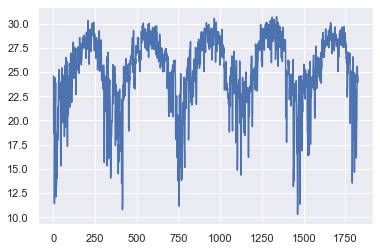

In [5]:
plt.plot(y_samp)

In [6]:
# Calculate moving average for precip
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_samp.shape[0]-avg_window):
    y_avg = np.mean(y_samp[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_samp[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_samp = y_movavg
X_samp = X_movavg

In [7]:
# Standardize data by z-scoring
mean = np.mean(y_samp)
std = np.std(y_samp)
y_samp = (y_samp-mean)/std
X_samp[:,0:16] = (X_samp[:,0:16] - np.mean(X_samp[:,0:16]))/np.std(X_samp[:,16])
X_samp[:,16] = (X_samp[:,16] - np.mean(X_samp[:,16]))/np.std(X_samp[:,16])
X_samp[:,17] = (X_samp[:,17] - np.mean(X_samp[:,17]))/np.std(X_samp[:,17])
X_samp[:,18] = (X_samp[:,18] - np.mean(X_samp[:,18]))/np.std(X_samp[:,18])

X = X_samp.copy()
y = y_samp.copy()




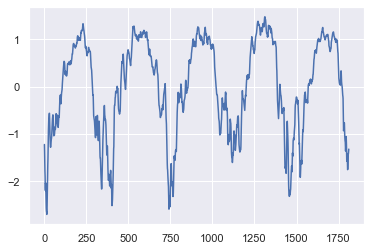

In [8]:
plt.plot(y_samp)

In [9]:
print(X.shape)
print(y.shape)

(1812, 19)
(1812,)


In [10]:
torch.zeros(3,3,1).shape

torch.Size([3, 3, 1])

In [11]:
# Create dataset by using the sliding window approach
# Input/Output pairs = (X_{t-iw+1:t}, y_{t+1:t+ow})
# Transformer takes same sequence length, so we have three approaches: (Assume iw > ow)
# 1. Use X_{t-iw:t} and [y_{t:t+ow}, 0,...,0]
# 2. Use X_{t-iw:t} and y_{t-(iw-ow):t+ow}
# 3. Use X_{t-iw:t} and t_{t:t+iw}
def create_sequence_padding(X,y, input_window,output_window): 
    L = X.shape[0]
    num_features = X.shape[1]
    X_samples = torch.zeros(L-input_window-output_window,input_window,num_features)
#     print(X_samples.shape)
    y_samples = torch.zeros(L-input_window-output_window,input_window,1)
#     print(y_samples.shape)
    for i in range(L-input_window-output_window):
        # Note that i goes from 0 to T - iw - ow, but our sample points are at t from iw - 1 to T - ow - 1
        # i.e. at each time point, t = i + iw - 1
        X_seq = X[i:i+input_window,:] # t - iw + 1 to t
        y_seq = y[i+input_window:i+input_window+output_window]
        y_seq = np.pad(y_seq,(0,input_window-output_window))
#         print(X_seq.shape)
#         print(y_seq.shape)
#         print(y_samples[i,:,:].shape)
        X_samples[i,:,:] = torch.from_numpy(X_seq)
        y_samples[i,:,0] = torch.from_numpy(y_seq)
    return X_samples,y_samples

X_samples, y_samples = create_sequence_padding(X,y,30,14)

print(X_samples.shape)
print(y_samples.shape)

torch.Size([1768, 30, 19])
torch.Size([1768, 30, 1])


In [12]:
# Approach 2
def create_sequence_shifting(X,y, input_window,output_window): 
    L = X.shape[0]
    num_features = X.shape[1]
    X_samples = torch.zeros(L-input_window-output_window,input_window,num_features)
#     print(X_samples.shape)
    y_samples = torch.zeros(L-input_window-output_window,input_window,1)
#     print(y_samples.shape)
    for i in range(L-input_window-output_window):
        # Note that i goes from 0 to T - iw - ow, but our sample points are at t from iw - 1 to T - ow - 1
        # i.e. at each time point, t = i + iw - 1
        X_seq = X[i:i+input_window,:] # t - iw + 1 to t
        y_seq = y[i+output_window:i+input_window+output_window]      
#         print(X_seq.shape)
#         print(y_seq.shape)
#         print(y_samples[i,:,:].shape)
        X_samples[i,:,:] = torch.from_numpy(X_seq)
        y_samples[i,:,0] = torch.from_numpy(y_seq)
    return X_samples,y_samples

X_samples, y_samples = create_sequence_shifting(X,y,30,14)
print(X_samples.shape)
print(y_samples.shape)

torch.Size([1768, 30, 19])
torch.Size([1768, 30, 1])


In [14]:
# Approach 3
def create_sequence_matching(X,y, input_window): 
    L = X.shape[0]
    num_features = X.shape[1]
    X_samples = torch.zeros(L-2*input_window,input_window,num_features)
#     print(X_samples.shape)
    y_samples = torch.zeros(L-2*input_window,input_window,1)
#     print(y_samples.shape)
    for i in range(L-2*input_window):
        # Note that i goes from 0 to T - iw - ow, but our sample points are at t from iw - 1 to T - ow - 1
        # i.e. at each time point, t = i + iw - 1
        X_seq = X[i:i+input_window,:] # t - iw + 1 to t
        y_seq = y[i+input_window:i+2*input_window]      
#         print(X_seq.shape)
#         print(y_seq.shape)
#         print(y_samples[i,:,:].shape)
        X_samples[i,:,:] = torch.from_numpy(X_seq)
        y_samples[i,:,0] = torch.from_numpy(y_seq)
    return X_samples,y_samples

X_samples, y_samples = create_sequence_matching(X,y,30)
print(X_samples.shape)
print(y_samples.shape)

torch.Size([1752, 30, 19])
torch.Size([1752, 30, 1])


In [14]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer
from tst.loss import OZELoss
import os

from src.dataset import OzeDataset
from src.utils import compute_loss
from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [15]:
# Training parameters
DATASET_PATH = 'data/data_gen_original.npz' #'datasets/dataset_57M.npz'
# BATCH_SIZE = 8
# NUM_WORKERS = 0
# LR = 2e-4
# EPOCHS = 30

# # Model parameters
# d_model = 64 # Lattent dim
# q = 8 # Query size
# v = 8 # Value size
# h = 8 # Number of heads
# N = 4 # Number of encoder and decoder to stack
# attention_size = 12 # Attention window size
# dropout = 0.2 # Dropout rate
# pe = None # Positional encoding
# chunk_mode = None

# d_input = 27 # From dataset
# d_output = 8 # From dataset

BATCH_SIZE = 8
NUM_WORKERS = 0
LR = 2e-4
EPOCHS = 30

# Model parameters
d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 12 # Attention window size
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 37 # From dataset
d_output = 8 # From dataset
